<a href="https://colab.research.google.com/github/PritishWadhwa/CM-Project/blob/master/squeezenet_bloodmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 8.6 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=77c4009199240b1bf6593061241f7e36a3bc3e40c30b1e31533bd8821f18c92f
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [2]:
from fastai.vision.all import *
from fastai import *
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms
from fastai.data.external import *

In [3]:
data_flag = 'bloodmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [4]:
DataClass=getattr(medmnist, info['python_class'])

In [5]:
train_dataset= DataClass(split='train',download=download)
val_dataset=DataClass(split='val',download=download)
test_dataset=DataClass(split='test',download=download)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [6]:
data={'Image':[],"Labels":[],"is_valid":[]}

In [7]:
for i in range(len(train_dataset)):
  data['Image'].append(train_dataset[i][0])
  data['Labels'].append(train_dataset[i][1][0])
  data['is_valid'].append(True)

for i in range(len(val_dataset)):
  data['Image'].append(val_dataset[i][0])
  data['Labels'].append(val_dataset[i][1][0])
  data['is_valid'].append(False)

In [8]:
train_df=pd.DataFrame.from_dict(data)
train_df

Image  Labels  is_valid
0      <PIL.Image.Image image mode=RGB size=28x28>       7      True
1      <PIL.Image.Image image mode=RGB size=28x28>       3      True
2      <PIL.Image.Image image mode=RGB size=28x28>       6      True
3      <PIL.Image.Image image mode=RGB size=28x28>       6      True
4      <PIL.Image.Image image mode=RGB size=28x28>       7      True
...                                            ...     ...       ...
13666  <PIL.Image.Image image mode=RGB size=28x28>       3     False
13667  <PIL.Image.Image image mode=RGB size=28x28>       6     False
13668  <PIL.Image.Image image mode=RGB size=28x28>       3     False
13669  <PIL.Image.Image image mode=RGB size=28x28>       1     False
13670  <PIL.Image.Image image mode=RGB size=28x28>       6     False

[13671 rows x 3 columns]

In [9]:
train_df=train_df.sample(frac = 1).reset_index(drop=True)
train_df

Image  Labels  is_valid
0      <PIL.Image.Image image mode=RGB size=28x28>       5      True
1      <PIL.Image.Image image mode=RGB size=28x28>       1      True
2      <PIL.Image.Image image mode=RGB size=28x28>       4      True
3      <PIL.Image.Image image mode=RGB size=28x28>       6      True
4      <PIL.Image.Image image mode=RGB size=28x28>       6     False
...                                            ...     ...       ...
13666  <PIL.Image.Image image mode=RGB size=28x28>       1      True
13667  <PIL.Image.Image image mode=RGB size=28x28>       1      True
13668  <PIL.Image.Image image mode=RGB size=28x28>       7      True
13669  <PIL.Image.Image image mode=RGB size=28x28>       0     False
13670  <PIL.Image.Image image mode=RGB size=28x28>       6      True

[13671 rows x 3 columns]

In [10]:
def get_x(r):
    img=r['Image']
    img=np.asarray(img)
    return (img).astype(np.uint8)

def get_y(r):
    return r["Labels"]

In [11]:
switch=True
block=""
if n_channels==1 and switch:
  block=(ImageBlock(cls=PILImageBW), CategoryBlock) 
else:
  block=(ImageBlock(), CategoryBlock)

dblock = DataBlock(
    blocks=block,
    get_x=get_x,
    get_y=get_y,
    splitter=ColSplitter()
)

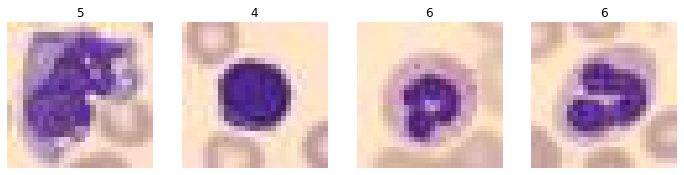

In [12]:
dls = dblock.dataloaders(train_df, bs=32)
dls.show_batch(nrows=1, ncols=4)

In [13]:
learn = vision_learner(dls, squeezenet1_0, metrics=accuracy)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [14]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)  

In [15]:
learn.metrics = accuracy
learn.validate() #(loss,accuracy)(for validation)

(#2) [3.594133138656616,0.7473869323730469]

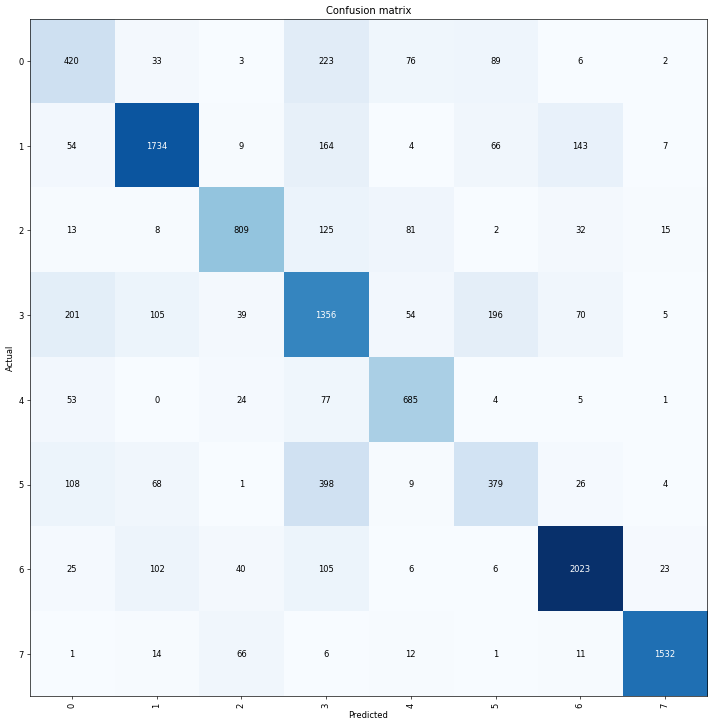

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # confusion matrix

In [18]:
predictions=[]
labels=[]
for i in range(len(test_dataset)):
  img=np.asarray(test_dataset[i][0])
  img=(img).astype(np.uint8)
  pred,_,probs=learn.predict(img)
  predictions.append(int(pred))
  labels.append(test_dataset[i][1][0])

In [19]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45       244
           1       0.83      0.79      0.81       624
           2       0.79      0.74      0.76       311
           3       0.53      0.64      0.58       579
           4       0.73      0.76      0.74       243
           5       0.54      0.36      0.43       284
           6       0.85      0.87      0.86       666
           7       0.96      0.94      0.95       470

    accuracy                           0.73      3421
   macro avg       0.71      0.69      0.70      3421
weighted avg       0.74      0.73      0.73      3421



In [ ]:
# resnet18, resnet34, resnet50, resnet101, resnet152
# vgg16_bn, vgg19_bn
# alexnet
# densenet121, densenet169, densenet201, densenet161
# squeezenet1_0, squeezenet1_1

## list of models

In [ ]:
#learner.export(export.pkl)
#learner = load_learner(path=learn.path) #store model

In [ ]:
#learn.lr_find() # to find optimal lr